In [45]:
import sys
import dill
import warnings
from functools import partial
from datetime import datetime


import os

#%load_ext cudf.pandas
import pandas as pd
import tqdm

import missingno as msno

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


from sklearn.utils import resample

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


from bayes_opt import BayesianOptimization


In [2]:
warnings.filterwarnings('ignore')

# Загрузка данных

In [4]:
path = 'train_data/'

In [5]:



def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [6]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных


   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [7]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=12,
                                    save_to_path='train_data/')

Transforming transactions data:   0%|          | 0/6 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
chunk_path train_data/train_data_9.pq


In [8]:
data.to_csv('dataset.csv', index=False)

In [22]:
data = pd.read_csv('dataset.csv')

In [4]:
targets = pd.read_csv('train_target.csv', index_col='id')
targets.head()

flag
id      
0      0
1      0
2      0
3      0
4      0

# Исследование

In [12]:
targets.flag.value_counts(normalize=True)*100

0    96.451933
1     3.548067
Name: flag, dtype: float64

Сильный дисбаланс. Попробуем downSumpling и upSumpling.

In [13]:
data.describe(include='all')

id            rn  pre_since_opened  pre_since_confirmed  \
count  2.616272e+07  2.616272e+07      2.616272e+07         2.616272e+07   
mean   1.545557e+06  7.047498e+00      9.363455e+00         8.223857e+00   
std    8.679880e+05  5.396749e+00      5.775058e+00         4.713167e+00   
min    0.000000e+00  1.000000e+00      0.000000e+00         0.000000e+00   
25%    7.949020e+05  3.000000e+00      4.000000e+00         4.000000e+00   
50%    1.568512e+06  6.000000e+00      9.000000e+00         9.000000e+00   
75%    2.303681e+06  1.000000e+01      1.400000e+01         1.200000e+01   
max    2.999999e+06  5.800000e+01      1.900000e+01         1.700000e+01   

          pre_pterm     pre_fterm  pre_till_pclose  pre_till_fclose  \
count  2.616272e+07  2.616272e+07     2.616272e+07     2.616272e+07   
mean   8.365817e+00  8.330814e+00     7.140610e+00     8.362821e+00   
std    5.324534e+00  4.477978e+00     5.152379e+00     4.223331e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00     0.000000e+00   
25%    4.000000e+00  6.000000e+00     2.000000e+00     5.000000e+00   
50%    8.000000e+00  8.000000e+00     7.000000e+00     1.000000e+01   
75%    1.400000e+01  1.200000e+01     1.200000e+01     1.100000e+01   
max    1.700000e+01  1.600000e+01     1.600000e+01     1.500000e+01   

       pre_loans_credit_limit  pre_loans_next_pay_summ  ...   enc_paym_21  \
count            2.616272e+07             2.616272e+07  ...  2.616272e+07   
mean             9.676587e+00             2.363715e+00  ...  2.316090e+00   
std              5.827325e+00             1.310304e+00  ...  1.245876e+00   
min              0.000000e+00             0.000000e+00  ...  0.000000e+00   
25%              5.000000e+00             2.000000e+00  ...  3.000000e+00   
50%              1.000000e+01             2.000000e+00  ...  3.000000e+00   
75%              1.500000e+01             2.000000e+00  ...  3.000000e+00   
max              1.900000e+01             6.000000e+00  ...  3.000000e+00   

        enc_paym_22   enc_paym_23   enc_paym_24  \
count  2.616272e+07  2.616272e+07  2.616272e+07   
mean   2.347714e+00  2.381380e+00  3.530334e+00   
std    1.225234e+00  1.202013e+00  1.080402e+00   
min    0.000000e+00  0.000000e+00  1.000000e+00   
25%    3.000000e+00  3.000000e+00  4.000000e+00   
50%    3.000000e+00  3.000000e+00  4.000000e+00   
75%    3.000000e+00  3.000000e+00  4.000000e+00   
max    3.000000e+00  3.000000e+00  4.000000e+00   

       enc_loans_account_holder_type  enc_loans_credit_status  \
count                   2.616272e+07             2.616272e+07   
mean                    1.034107e+00             2.693111e+00   
std                     3.048805e-01             4.997517e-01   
min                     0.000000e+00             0.000000e+00   
25%                     1.000000e+00             2.000000e+00   
50%                     1.000000e+00             3.000000e+00   
75%                     1.000000e+00             3.000000e+00   
max                     6.000000e+00             6.000000e+00   

       enc_loans_credit_type  enc_loans_account_cur   pclose_flag  \
count           2.616272e+07           2.616272e+07  2.616272e+07   
mean            3.519057e+00           1.001717e+00  1.491979e-01   
std             1.037642e+00           4.880076e-02  3.562835e-01   
min             0.000000e+00           0.000000e+00  0.000000e+00   
25%             3.000000e+00           1.000000e+00  0.000000e+00   
50%             4.000000e+00           1.000000e+00  0.000000e+00   
75%             4.000000e+00           1.000000e+00  0.000000e+00   
max             7.000000e+00           3.000000e+00  1.000000e+00   

        fclose_flag  
count  2.616272e+07  
mean   2.289680e-01  
std    4.201686e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

[8 rows x 61 columns]

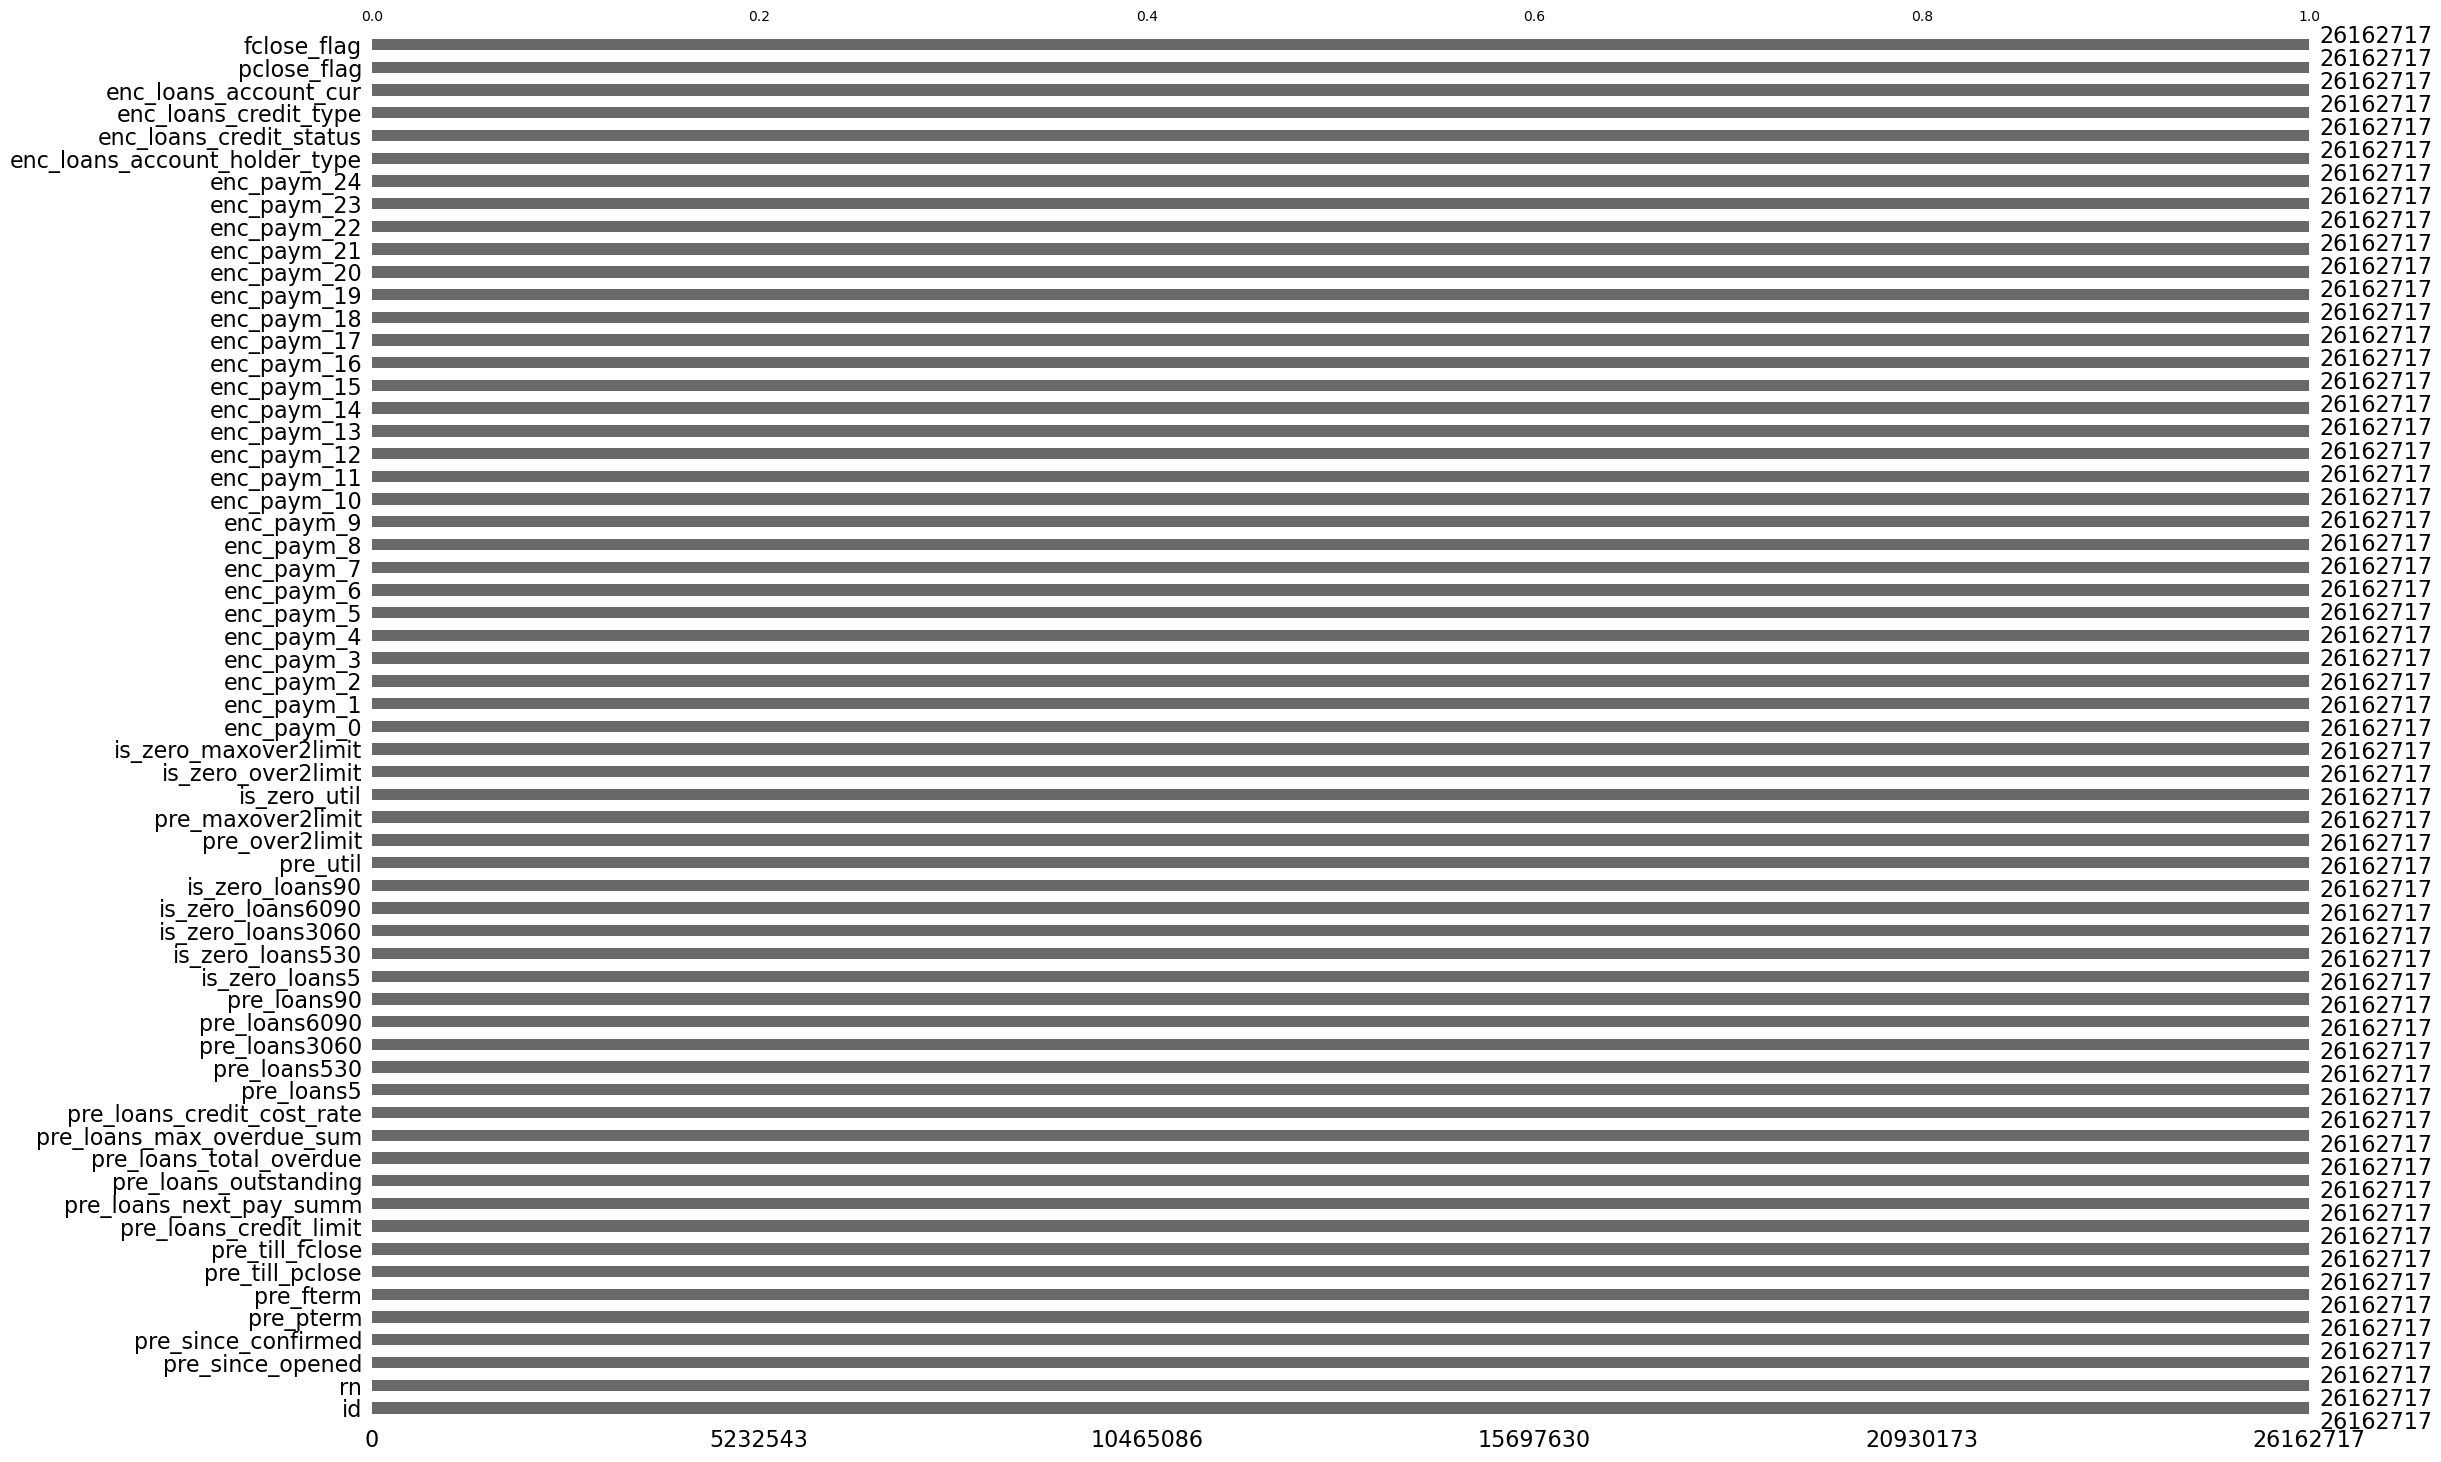

In [8]:
msno.bar(data);

In [23]:
flag_cols = ['is_zero_loans5','is_zero_loans530','is_zero_loans3060','is_zero_loans6090','is_zero_loans90']

In [35]:
print('Процентаж кредитов без задолжностей\n')
for col in flag_cols:
    print(f'column: {col}\n percentage:\n{data[col].value_counts(normalize=True)*100}\n')

Процентаж кредитов без задолжностей

column: is_zero_loans5
 percentage:
1    91.870661
0     8.129339
Name: is_zero_loans5, dtype: float64

column: is_zero_loans530
 percentage:
1    83.221097
0    16.778903
Name: is_zero_loans530, dtype: float64

column: is_zero_loans3060
 percentage:
1    95.736016
0     4.263984
Name: is_zero_loans3060, dtype: float64

column: is_zero_loans6090
 percentage:
1    97.54313
0     2.45687
Name: is_zero_loans6090, dtype: float64

column: is_zero_loans90
 percentage:
1    97.601667
0     2.398333
Name: is_zero_loans90, dtype: float64



# Feature_engineering

Просуммируем количество всех признаков по id(кроме rn - номер заявки). По столбцу rn посчитаем общее количество заявок. Добавим в таблицу данные по последней(наиболее актуальной) заявке.
Объединяем полученную таблицу с целевой переменной и проверяем на пропуски.

In [5]:
def aggregate(data: pd.DataFrame):
    df_agg = data[['id', 'rn']].copy()
    features = set(data.columns) - set(['id','rn'])
    dummies = pd.get_dummies(data[features], columns=features)
    df_agg = pd.concat([df_agg, dummies], axis=1)
    agg_d = {f: 'sum' for f in set(df_agg) - set(['id','rn'])}
    agg_d['rn'] = 'count'
    df_agg = df_agg.groupby('id').agg(agg_d).astype('int8')
    
    df = df_agg.merge(data, left_on=['id', 'rn'], right_on=['id', 'rn'], how='inner').astype('int8')
    df = df.drop('id', axis=1)
    df = df.join(targets)
    
    return df

In [6]:
df = aggregate(data)

# Full df analys

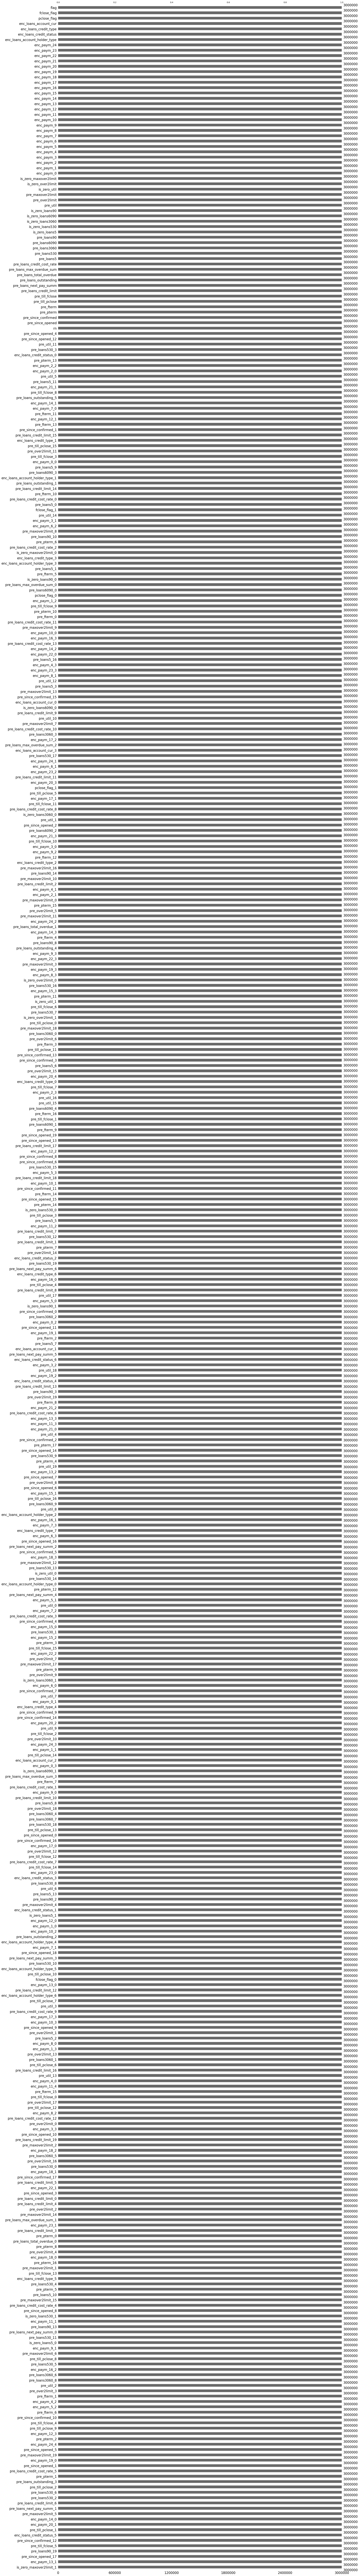

In [12]:
msno.bar(df);

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000000 entries, 0 to 2999999
Columns: 480 entries, is_zero_maxover2limit_1 to flag
dtypes: int64(1), int8(479)
memory usage: 1.4 GB


In [38]:
print('Количество кредитов')
df['rn'].value_counts(normalize=True)*100

Количество кредитов


3     7.669300
2     7.621500
4     7.551433
1     7.351500
5     7.255967
6     6.932433
7     6.484633
8     5.986300
9     5.470167
10    4.934967
11    4.402067
12    3.898067
13    3.431833
14    2.990733
15    2.754900
16    2.487267
17    2.275000
18    2.016833
19    1.766233
20    1.493700
21    1.225100
22    0.972233
23    0.769333
24    0.576767
25    0.435667
26    0.322800
27    0.241600
28    0.179900
29    0.133433
30    0.101467
31    0.073033
32    0.054333
33    0.040700
34    0.030033
35    0.020533
36    0.015333
37    0.010833
38    0.007367
39    0.005367
40    0.003400
41    0.001833
42    0.001600
43    0.001133
45    0.000500
44    0.000300
46    0.000167
51    0.000067
50    0.000067
49    0.000067
47    0.000067
54    0.000033
55    0.000033
48    0.000033
58    0.000033
Name: rn, dtype: float64

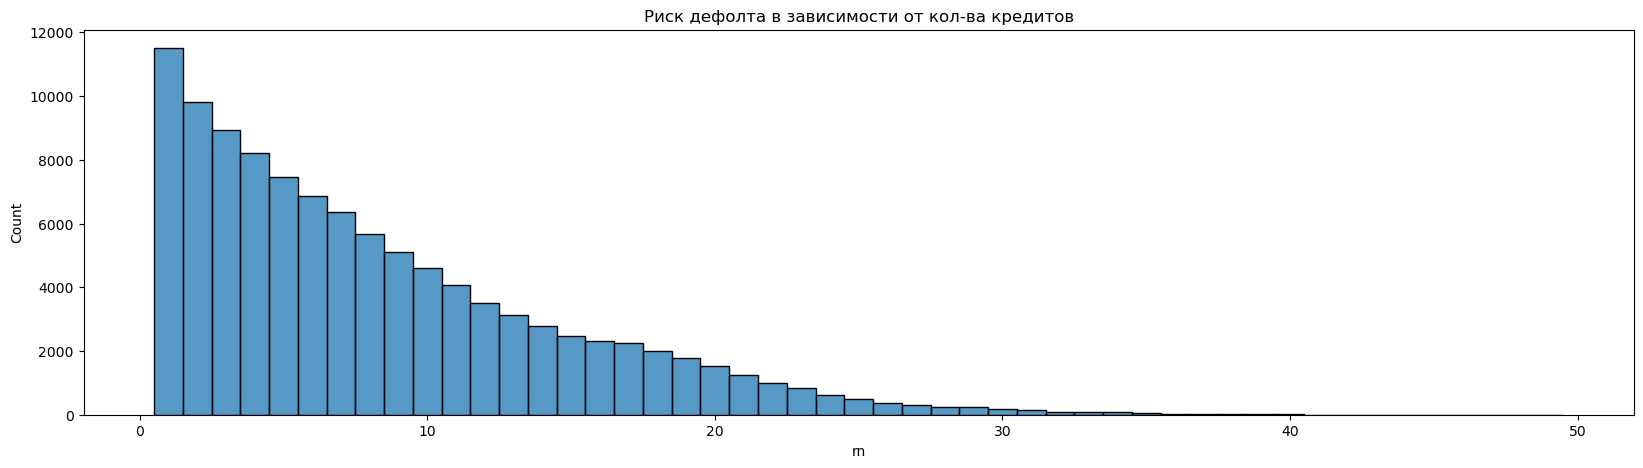

In [47]:
plt.figure(figsize=(20, 5))
sns.histplot(df[df.flag == 1], x='rn', discrete=True)
plt.title('Риск дефолта в зависимости от кол-ва кредитов');

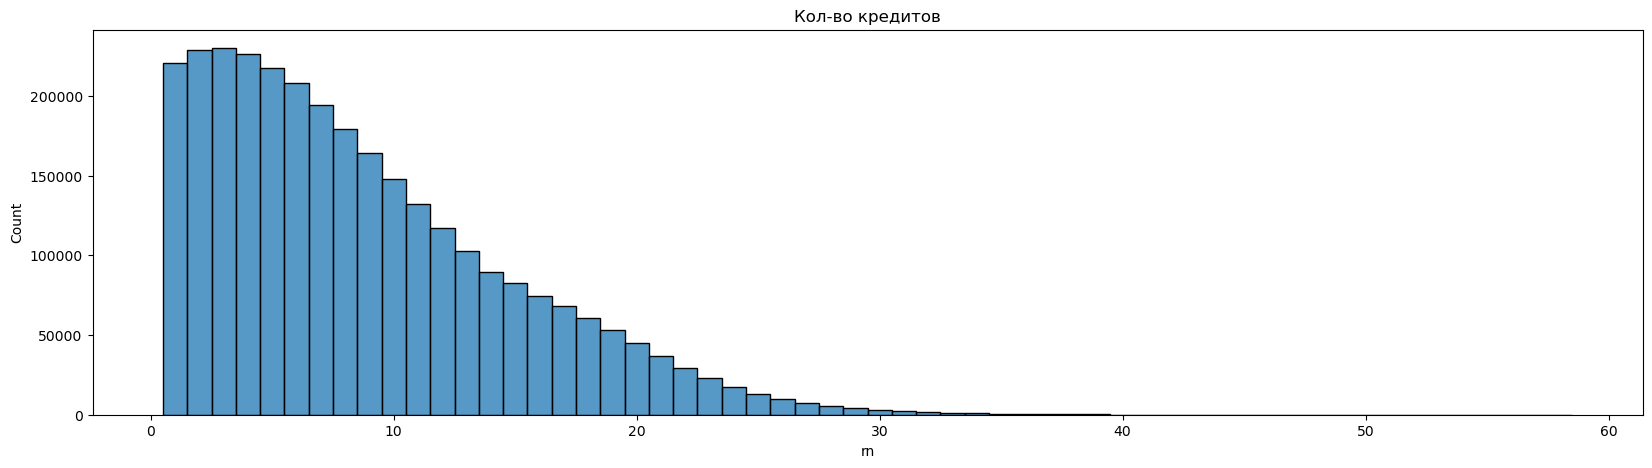

In [48]:
plt.figure(figsize=(20, 5))
sns.histplot(df, x='rn', discrete=True)
plt.title('Кол-во кредитов');

In [50]:
def percentage(data: pd.DataFrame, column: str):
    group = data.groupby(column)
    result = pd.DataFrame(index=group.groups)
    result.index.name = column
    result['Кол-во'] = group[column].count()
    result['% от общего'] = result['Кол-во'] / len(data)
    result['кол-во дефолтов'] = group.flag.sum()
    result['% дефолтов'] = result['кол-во дефолтов'] / result['Кол-во']
    result = result.sort_values(['% дефолтов'], ascending=False)
    result['% от общего'] = result['% от общего'].apply(lambda x: f'{x*100:0.2f}%')
    result['% дефолтов'] = result['% дефолтов'].apply(lambda x: f'{x*100:0.2f}%')
    return(result)

In [51]:
percentage(df, 'rn')

Кол-во % от общего  кол-во дефолтов % дефолтов
rn                                                
49       2       0.00%                1     50.00%
43      34       0.00%                4     11.76%
38     221       0.01%               25     11.31%
40     102       0.00%               10      9.80%
34     901       0.03%               77      8.55%
36     460       0.02%               36      7.83%
35     616       0.02%               48      7.79%
33    1221       0.04%               88      7.21%
45      15       0.00%                1      6.67%
39     161       0.01%               10      6.21%
32    1630       0.05%              100      6.13%
31    2191       0.07%              134      6.12%
37     325       0.01%               19      5.85%
29    4003       0.13%              230      5.75%
30    3044       0.10%              174      5.72%
41      55       0.00%                3      5.45%
1   220545       7.35%            11506      5.22%
28    5397       0.18%              235      4.35%
2   228645       7.62%             9823      4.30%
42      48       0.00%                2      4.17%
27    7248       0.24%              296      4.08%
26    9684       0.32%              383      3.95%
3   230079       7.67%             8934      3.88%
25   13070       0.44%              480      3.67%
24   17303       0.58%              634      3.66%
23   23080       0.77%              841      3.64%
4   226543       7.55%             8199      3.62%
5   217679       7.26%             7474      3.43%
22   29167       0.97%              994      3.41%
20   44811       1.49%             1516      3.38%
21   36753       1.23%             1242      3.38%
19   52987       1.77%             1765      3.33%
18   60505       2.02%             2009      3.32%
6   207973       6.93%             6868      3.30%
7   194539       6.48%             6376      3.28%
17   68250       2.27%             2236      3.28%
8   179589       5.99%             5677      3.16%
10  148049       4.93%             4614      3.12%
9   164105       5.47%             5097      3.11%
14   89722       2.99%             2783      3.10%
16   74618       2.49%             2312      3.10%
11  132062       4.40%             4069      3.08%
13  102955       3.43%             3122      3.03%
15   82647       2.75%             2485      3.01%
12  116942       3.90%             3510      3.00%
44       9       0.00%                0      0.00%
46       5       0.00%                0      0.00%
47       2       0.00%                0      0.00%
48       1       0.00%                0      0.00%
50       2       0.00%                0      0.00%
51       2       0.00%                0      0.00%
54       1       0.00%                0      0.00%
55       1       0.00%                0      0.00%
58       1       0.00%                0      0.00%

In [56]:
print('Процентаж кредитов без задолжностей\n')
for col in flag_cols:
    column = col+'_0'
    print(f'column: {column}\n percentage:\n{percentage(df, column)}\n')


Процентаж кредитов без задолжностей

column: is_zero_loans5_0
 percentage:
                   Кол-во % от общего  кол-во дефолтов % дефолтов
is_zero_loans5_0                                                 
14                      9       0.00%                1     11.11%
11                    194       0.01%               14      7.22%
12                     87       0.00%                6      6.90%
9                     943       0.03%               50      5.30%
10                    444       0.01%               22      4.95%
8                    2147       0.07%              106      4.94%
5                   25668       0.86%             1179      4.59%
4                   57876       1.93%             2632      4.55%
13                     45       0.00%                2      4.44%
6                   11268       0.38%              493      4.38%
3                  129402       4.31%             5659      4.37%
2                  289296       9.64%            12148      4.20%
7

In [7]:
del(data, targets)

## train_test_split

In [8]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(df.drop('flag', axis=1), df['flag'], 
                                                                test_size=0.3, stratify=df['flag'], random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.3, stratify=y_train_valid, random_state=42)

In [9]:
print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер валидационной выборки: {X_valid.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (1470000, 479)
Размер валидационной выборки: (630000, 479)
Размер тестовой выборки: (900000, 479)


## Поиск лучшего порога

Требуемая метрика не задана = выберем f1.

In [10]:
def find_threshold(y: pd.Series, y_proba: pd.Series, best_threshold: float = 0.5, metric_name: str='roc_auc') -> float:    
    
    def f1(threshold: float) -> float:
        predict = (y_proba > threshold).astype(int)
        return f1_score(y, predict)
    
    best_metric = f1(best_threshold)
    direction = 1
    shift = 0.2
    
    for i in range(300):
        threshold = best_threshold + direction*shift
        shift *= 0.9
        metric = f1(threshold)
        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold
        else:
            direction *= -1
    return best_threshold

## Вывод метрик

In [11]:
def print_metrics(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> None:
    probas = model.predict_proba(X)[:, 1]
    threshold = find_threshold(y, probas)
    predict = (probas>threshold).astype(int)
    
    print(f"{roc_auc_score(y, probas)} - roc_auc на вероятностях")
    print(f'best threshold: {threshold}')
#    print(f'roc-auc: {roc_auc_score(y, predict)}')
    print(f'accuracy: {accuracy_score(y, predict)}')
    print(f'recall: {recall_score(y, predict)}')
    print(f'precision: {precision_score(y, predict)}')
    print(f'f1: {f1_score(y, predict)}\n')
    print(confusion_matrix(y, predict))
        

## Decision Tree

In [19]:
tree = DecisionTreeClassifier(random_state=42)

In [20]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [21]:
print_metrics(tree, X_valid, y_valid)

0.524589266231295 - roc_auc на вероятностях
best threshold: 0.012199999999999878
accuracy: 0.9258142857142857
recall: 0.0929181765311144
precision: 0.07278015277875113
f1: 0.08162543475270675

[[581186  26461]
 [ 20276   2077]]


## Logistic regression

In [97]:
def optimization_lr(
    max_iter: float,
    C: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('model', LogisticRegression(max_iter=int(max_iter), C=C))])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [98]:
optimizing_parameters_lr = {
    'C': (0.5, 3), 
    'max_iter': (50, 500)
    }

In [99]:
best_score_lr, best_parameters_lr = 0.0, dict()

optimizer_lr = BayesianOptimization(
    optimization_lr, 
    optimizing_parameters_lr, random_state=42)
optimizer_lr.maximize(init_points=3, n_iter=2)
    
best_score_lr = optimizer_lr.max['target']
best_parameters_lr.update(optimizer_lr.max['params'])

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.7362    | 1.436     | 477.8     |
| 2         | 0.7361    | 2.33      | 319.4     |
| 3         | 0.7345    | 0.89      | 120.2     |
| 4         | 0.7362    | 0.7088    | 399.7     |
| 5         | 0.7362    | 2.244     | 399.4     |


## Gradient Boosting

In [57]:
def optimization_hb(
    max_iter: float,
    min_samples_leaf: float,
    max_leaf_nodes: float,
    max_bins: float,
    learning_rate: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('model', HistGradientBoostingClassifier(max_iter=int(max_iter), max_bins=int(max_bins),learning_rate=learning_rate, min_samples_leaf=int(min_samples_leaf), max_leaf_nodes=int(max_leaf_nodes)))])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [58]:
optimizing_parameters_hb = {
    'learning_rate': (0.01, 0.2), 
    'max_iter': (50, 500),
    'max_leaf_nodes': (15, 60),
    'min_samples_leaf': (12, 35),
    'max_bins': (100, 255)
    }

In [59]:
best_score_hb, best_parameters_hb = 0.0, dict()

optimizer_hb = BayesianOptimization(
    optimization_hb, 
    optimizing_parameters_hb, random_state=42)
optimizer_hb.maximize(init_points=3, n_iter=2)
    
best_score_hb = optimizer_hb.max['target']
best_parameters_hb.update(optimizer_hb.max['params'])

|   iter    |  target   | learni... | max_bins  | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | 0.7621    | 0.08116   | 247.4     | 379.4     | 41.94     | 15.59     |
| 2         | 0.7647    | 0.03964   | 109.0     | 439.8     | 42.05     | 28.29     |
| 3         | 0.7575    | 0.01391   | 250.3     | 424.6     | 24.56     | 16.18     |
| 4         | 0.7601    | 0.1858    | 108.4     | 439.4     | 38.01     | 26.24     |
| 5         | 0.76      | 0.1822    | 116.3     | 116.3     | 56.64     | 29.73     |


## LGBM

In [25]:
def optimization_lgbm(
    n_estimators: float, 
    num_leaves: float, 
    learning_rate: float, 
    reg_lambda: float, 
    reg_alpha: float, 
    min_child_samples: float,
    boosting_type: str = 'goss'
) -> float:
    
    
    model = Pipeline(steps=[
        ('model', LGBMClassifier(n_estimators=int(n_estimators), num_leaves=int(num_leaves), learning_rate=learning_rate, reg_lambda=reg_lambda,
                    reg_alpha=reg_alpha, min_child_samples=int(min_child_samples), boosting_type=boosting_type, random_state=42))])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)
   

In [26]:
optimizing_parameters_lgbm = {
    'n_estimators': (500, 5000), 
    'num_leaves': (10, 120), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50),  
    'reg_alpha': (0, 50),
    'min_child_samples': (10, 45)}

In [27]:
best_score_lgbm, best_parameters_lgbm = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer_lgbm = BayesianOptimization(
        partial(optimization_lgbm, boosting_type=boosting_type), 
        optimizing_parameters_lgbm, random_state=42)
    optimizer_lgbm.maximize(init_points=5, n_iter=3)
    
    if best_score_lgbm < optimizer_lgbm.max['target']:
        best_score_lgbm = optimizer_lgbm.max['target']
        best_parameters_lgbm.update(optimizer_lgbm.max['params'])
        best_parameters_lgbm['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   | learni... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7523    | 0.09989   | 43.28     | 3.794e+03 | 75.85     | 7.801     | 7.8       |
| 2         | 0.7692    | 0.02394   | 40.32     | 3.205e+03 | 87.89     | 1.029     | 48.5      |
| 3         | 0.7611    | 0.2098    | 17.43     | 1.318e+03 | 30.17     | 15.21     | 26.24     |
| 4         | 0.7647    | 0.1137    | 20.19     | 3.253e+03 | 25.34     | 14.61     | 18.32     |
| 5         | 0.7646    | 0.1195    | 37.48     | 1.399e+03 | 66.57     | 29.62     | 2.323     |
| 6         | 0.741     | 0.2404    | 33.75     | 3.068e+03 | 114.0     | 22.15     | 29.96     |
| 7         | 0.7685    | 0.06496   | 32.01     | 3.247e+03 | 19.26     | 16.53     | 10.37     |
| 8         | 0.7648    | 0.1421    | 32.09     | 3.248e+03 | 13.86     | 8.339     | 19.76     |

# С выбором категорий

## Logistic regression

In [80]:
def optimization_lr_kbest(
    k: float,
    max_iter: float,
    C: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', LogisticRegression(max_iter=int(max_iter), C=C))])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [83]:
optimizing_parameters_lr_kbest = {
    'C': (0.5, 3), 
    'max_iter': (50, 500),
    'k': (200, 480),  
    }

In [84]:
best_score_lr_kbest, best_parameters_lr_kbest = 0.0, dict()

optimizer_lr_kbest = BayesianOptimization(
    optimization_lr_kbest, 
    optimizing_parameters_lr_kbest, random_state=42)
optimizer_lr_kbest.maximize(init_points=3, n_iter=2)
    
best_score_lr_kbest = optimizer_lr_kbest.max['target']
best_parameters_lr_kbest.update(optimizer_lr_kbest.max['params'])

|   iter    |  target   |     C     |     k     | max_iter  |
-------------------------------------------------------------
| 1         | 0.7361    | 1.436     | 466.2     | 379.4     |
| 2         | 0.7295    | 1.997     | 243.7     | 120.2     |
| 3         | 0.7362    | 0.6452    | 442.5     | 320.5     |
| 4         | 0.7311    | 1.056     | 244.5     | 499.6     |
| 5         | 0.7361    | 2.652     | 467.0     | 379.1     |


## Gradient Boosting

In [86]:
def optimization_hb_kbest(
    k: float,
    max_iter: float,
    min_samples_leaf: float,
    max_leaf_nodes: float,
    max_bins: float,
    learning_rate: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', HistGradientBoostingClassifier(max_iter=int(max_iter), max_bins=int(max_bins),learning_rate=learning_rate, min_samples_leaf=int(min_samples_leaf), max_leaf_nodes=int(max_leaf_nodes)))])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [87]:
optimizing_parameters_hb_kbest = {
    'learning_rate': (0.01, 0.2), 
    'max_iter': (50, 500),
    'k': (200,480),
    'max_leaf_nodes': (15, 60),
    'min_samples_leaf': (12, 35),
    'max_bins': (100, 255)
    }

In [90]:
best_score_hb_kbest, best_parameters_hb_kbest = 0.0, dict()

optimizer_hb = BayesianOptimization(
    optimization_hb_kbest, 
    optimizing_parameters_hb_kbest, random_state=42)
optimizer_hb_kbest.maximize(init_points=3, n_iter=2)
    
best_score_hb_kbest = optimizer_hb_kbest.max['target']
best_parameters_hb_kbest.update(optimizer_hb_kbest.max['params'])

|   iter    |  target   |     k     | learni... | max_bins  | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7554    | 304.9     | 0.1906    | 213.5     | 319.4     | 22.02     | 15.59     |
| 2         | 0.753     | 216.3     | 0.1746    | 193.2     | 368.6     | 15.93     | 34.31     |
| 3         | 0.7568    | 433.1     | 0.05034   | 128.2     | 132.5     | 28.69     | 24.07     |
| 4         | 0.7587    | 424.2     | 0.1947    | 133.3     | 134.1     | 35.47     | 29.2      |
| 5         | 0.7608    | 415.0     | 0.09609   | 130.6     | 129.0     | 36.97     | 30.02     |


## LGBM

In [22]:
def optimization_lgbm_kbest(
    k: float,
    n_estimators: float, 
    num_leaves: float, 
    learning_rate: float, 
    reg_lambda: float, 
    reg_alpha: float, 
    min_child_samples: float,
    boosting_type: str = 'goss'
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(mutual_info_classif, k=int(k))),
        ('model', LGBMClassifier(n_estimators=int(n_estimators), num_leaves=int(num_leaves), learning_rate=learning_rate, reg_lambda=reg_lambda,
                    reg_alpha=reg_alpha, min_child_samples=int(min_child_samples), boosting_type=boosting_type, random_state=42))])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)
   

In [23]:
optimizing_parameters_lgbm_kbest = {
    'k': (350,480),
    'n_estimators': (500, 5000), 
    'num_leaves': (10, 120), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50),  
    'reg_alpha': (0, 50),
    'min_child_samples': (10, 45)}

In [24]:
best_score_lgbm_kbest, best_parameters_lgbm_kbest = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer_lgbm_kbest = BayesianOptimization(
        partial(optimization_lgbm_kbest, boosting_type=boosting_type), 
        optimizing_parameters_lgbm_kbest, random_state=42)
    optimizer_lgbm_kbest.maximize(init_points=5, n_iter=3)
    
    if best_score_lgbm_kbest < optimizer_lgbm_kbest.max['target']:
        best_score_lgbm_kbest = optimizer_lgbm_kbest.max['target']
        best_parameters_lgbm_kbest.update(optimizer_lgbm_kbest.max['params'])
        best_parameters_lgbm_kbest['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   |     k     | learni... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7411    | 398.7     | 0.2382    | 35.62     | 3.194e+03 | 27.16     | 7.8       | 2.904     |
| 2         | 0.7648    | 462.6     | 0.1543    | 34.78     | 592.6     | 116.7     | 41.62     | 10.62     |
| 3         | 0.7675    | 373.6     | 0.05402   | 20.65     | 2.861e+03 | 57.51     | 14.56     | 30.59     |
| 4         | 0.7614    | 368.1     | 0.08011   | 22.82     | 2.552e+03 | 96.37     | 9.984     | 25.71     |
| 5         | 0.7646    | 427.0     | 0.02115   | 31.26     | 1.267e+03 | 17.16     | 47.44     | 48.28     |
| 6         | 0.7681    | 371.6     | 0.05161   | 26.71     | 2.866e+03 | 47.52     | 15.65     | 21.57     |
| 7         | 0.7496    | 369.3     | 0.1683    | 16.84     | 2.857e+03 | 57.85     | 10.03     | 3

# DownSampling

In [45]:
df_full = X_train.join(y_train)

In [47]:
df_true = df_full[df_full['flag'] == 1]
df_false = df_full[df_full['flag'] == 0]

In [48]:
df_true.shape

(59874, 480)

In [68]:
df_false_downsample = resample(df_false, replace=False, n_samples=len(dfdf_true), random_state=42)
X_false_downsample.shape

(59874, 479)

In [69]:
df_downsample = pd.concat([df_true, df_false_downsample], ignore_index=True)
df_downsample

enc_paym_15_2  enc_paym_16_3  pre_since_confirmed_11  \
0                   0              5                       0   
1                   0             17                       1   
2                   0              5                       0   
3                   0              3                       0   
4                   0             17                       1   
...               ...            ...                     ...   
119743              0              1                       0   
119744              0              5                       0   
119745              0              4                       0   
119746              0              8                       0   
119747              0              2                       0   

        is_zero_loans5_1  pre_loans_credit_limit_18  \
0                      7                          1   
1                     21                          1   
2                      6                          0   
3                      9                          0   
4                     19                          0   
...                  ...                        ...   
119743                 3                          0   
119744                 6                          0   
119745                 4                          0   
119746                10                          0   
119747                 2                          0   

        pre_loans_credit_cost_rate_6  pre_loans_total_overdue_1  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   
3                                  0                          0   
4                                  0                          0   
...                              ...                        ...   
119743                             0                          0   
119744                             0                          0   
119745                             0                          0   
119746                             0                          0   
119747                             0                          0   

        is_zero_loans6090_1  pre_loans530_12  enc_paym_19_2  ...  enc_paym_22  \
0                         7                0              0  ...            3   
1                        21                0              0  ...            3   
2                         6                0              0  ...            3   
3                        11                0              0  ...            3   
4                        20                0              0  ...            3   
...                     ...              ...            ...  ...          ...   
119743                    3                0              0  ...            3   
119744                    7                0              0  ...            3   
119745                    5                0              0  ...            3   
119746                   10                0              0  ...            3   
119747                    2                0              0  ...            3   

        enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
0                 3            4                              1   
1                 3            4                              1   
2                 3            4                              1   
3                 3            4                              1   
4                 3            4                              1   
...             ...          ...                            ...   
119743            3            4                              1   
119744            3            4                              1   
119745            3            4                              1   
119746            3            4                              1   
119747            3            4                              1

## Logistic regression

In [62]:
def optimization_lr_ds(
    k: float,
    max_iter: float,
    C: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', LogisticRegression(max_iter=int(max_iter), C=C))])
    model.fit(df_downsample.drop('flag', axis=1), df_downsample['flag'])
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [63]:
optimizing_parameters_lr_ds = {
    'C': (0.5, 3), 
    'max_iter': (50, 500),
    'k': (200, 480),  
    }

In [74]:
best_score_lr_ds, best_parameters_lr_ds = 0.0, dict()

optimizer_lr_ds = BayesianOptimization(
    optimization_lr_ds, 
    optimizing_parameters_lr_ds, random_state=42)
optimizer_lr_ds.maximize(init_points=3, n_iter=2)
    
best_score_lr_ds = optimizer_lr_ds.max['target']
best_parameters_lr_ds.update(optimizer_lr_ds.max['params'])

|   iter    |  target   |     C     |     k     | max_iter  |
-------------------------------------------------------------
| 1         | 0.7383    | 1.436     | 466.2     | 379.4     |
| 2         | 0.7312    | 1.997     | 243.7     | 120.2     |
| 3         | 0.738     | 0.6452    | 442.5     | 320.5     |
| 4         | 0.7332    | 1.056     | 244.5     | 499.6     |
| 5         | 0.7384    | 2.652     | 467.0     | 379.1     |


## Gradient Boosting

In [75]:
def optimization_hb_ds(
    k: float,
    max_iter: float,
    min_samples_leaf: float,
    max_leaf_nodes: float,
    max_bins: float,
    learning_rate: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', HistGradientBoostingClassifier(max_iter=int(max_iter), max_bins=int(max_bins),learning_rate=learning_rate, min_samples_leaf=int(min_samples_leaf), max_leaf_nodes=int(max_leaf_nodes)))])
    model.fit(df_downsample.drop('flag', axis=1), df_downsample['flag'])
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [76]:
optimizing_parameters_hb_ds = {
    'learning_rate': (0.01, 0.2), 
    'max_iter': (50, 500),
    'k': (200,480),
    'max_leaf_nodes': (15, 60),
    'min_samples_leaf': (12, 35),
    'max_bins': (100, 255)
    }

In [77]:
best_score_hb_ds, best_parameters_hb_ds = 0.0, dict()

optimizer_hb_ds = BayesianOptimization(
    optimization_hb_ds, 
    optimizing_parameters_hb_ds, random_state=42)
optimizer_hb_ds.maximize(init_points=3, n_iter=2)
    
best_score_hb_ds = optimizer_hb_ds.max['target']
best_parameters_hb_ds.update(optimizer_hb_ds.max['params'])

|   iter    |  target   |     k     | learni... | max_bins  | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7552    | 304.9     | 0.1906    | 213.5     | 319.4     | 22.02     | 15.59     |
| 2         | 0.7534    | 216.3     | 0.1746    | 193.2     | 368.6     | 15.93     | 34.31     |
| 3         | 0.7563    | 433.1     | 0.05034   | 128.2     | 132.5     | 28.69     | 24.07     |
| 4         | 0.7574    | 424.2     | 0.1947    | 133.3     | 134.1     | 35.47     | 29.2      |
| 5         | 0.7594    | 415.0     | 0.09609   | 130.6     | 129.0     | 36.97     | 30.02     |


## LGBM

In [78]:
def optimization_lgbm_ds(
    k: float,
    n_estimators: float, 
    num_leaves: float, 
    learning_rate: float, 
    reg_lambda: float, 
    reg_alpha: float, 
    min_child_samples: float,
    boosting_type: str = 'goss'
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', LGBMClassifier(n_estimators=int(n_estimators), num_leaves=int(num_leaves), learning_rate=learning_rate, reg_lambda=reg_lambda,
                    reg_alpha=reg_alpha, min_child_samples=int(min_child_samples), boosting_type=boosting_type, random_state=42))])
    model.fit(df_downsample.drop('flag', axis=1), df_downsample['flag'])
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)
   

In [79]:
optimizing_parameters_lgbm_ds = {
    'k': (200,480),
    'n_estimators': (500, 5000), 
    'num_leaves': (10, 120), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50),  
    'reg_alpha': (0, 50),
    'min_child_samples': (10, 45)}

In [80]:
best_score_lgbm_ds, best_parameters_lgbm_ds = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer_lgbm_ds = BayesianOptimization(
        partial(optimization_lgbm_ds, boosting_type=boosting_type), 
        optimizing_parameters_lgbm_ds, random_state=42)
    optimizer_lgbm_ds.maximize(init_points=3, n_iter=2)
    
    if best_score_lgbm_ds < optimizer_lgbm_ds.max['target']:
        best_score_lgbm_ds = optimizer_lgbm_ds.max['target']
        best_parameters_lgbm_ds.update(optimizer_lgbm_ds.max['params'])
        best_parameters_lgbm_ds['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   |     k     | learni... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7437    | 304.9     | 0.2382    | 35.62     | 3.194e+03 | 27.16     | 7.8       | 2.904     |
| 2         | 0.7605    | 442.5     | 0.1543    | 34.78     | 592.6     | 116.7     | 41.62     | 10.62     |
| 3         | 0.7554    | 250.9     | 0.05402   | 20.65     | 2.861e+03 | 57.51     | 14.56     | 30.59     |
| 4         | 0.7556    | 246.5     | 0.05161   | 26.71     | 2.866e+03 | 47.52     | 15.65     | 21.57     |
| 5         | 0.7451    | 241.5     | 0.1683    | 16.84     | 2.857e+03 | 57.85     | 10.03     | 38.99     |
boosting_type = goss
|   iter    |  target   |     k     | learni... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... |
------------------------------------------------------------------------------

# UpSamping

In [82]:
df_false.shape

(1627626, 480)

In [86]:
df_true_upsample = resample(df_true, replace=True, n_samples=len(df_false), random_state=42)
df_true_upsample.shape

(1627626, 480)

In [87]:
df_upsample = pd.concat([df_false, df_true_upsample], ignore_index=True)

## Logistic regression

In [88]:
def optimization_lr_us(
    k: float,
    max_iter: float,
    C: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', LogisticRegression(max_iter=int(max_iter), C=C))])
    model.fit(df_upsample.drop('flag', axis=1), df_upsample['flag'])
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [89]:
optimizing_parameters_lr_us = {
    'C': (0.5, 3), 
    'max_iter': (50, 500),
    'k': (200, 480),  
    }

In [90]:
best_score_lr_us, best_parameters_lr_us = 0.0, dict()

optimizer_lr = BayesianOptimization(
    optimization_lr_us, 
    optimizing_parameters_lr_us, random_state=42)
optimizer_lr_us.maximize(init_points=3, n_iter=2)
    
best_score_lr_us = optimizer_lr_us.max['target']
best_parameters_lr_us.update(optimizer_lr_us.max['params'])

|   iter    |  target   |     C     |     k     | max_iter  |
-------------------------------------------------------------
| 1         | 0.7392    | 1.436     | 466.2     | 379.4     |
| 2         | 0.7315    | 1.997     | 243.7     | 120.2     |
| 3         | 0.739     | 0.6452    | 442.5     | 320.5     |
| 4         | 0.7341    | 1.056     | 244.5     | 499.6     |
| 5         | 0.739     | 2.652     | 467.0     | 379.1     |


## Gradient Boosting

In [91]:
def optimization_hb_us(
    k: float,
    max_iter: float,
    min_samples_leaf: float,
    max_leaf_nodes: float,
    max_bins: float,
    learning_rate: float
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', HistGradientBoostingClassifier(max_iter=int(max_iter), max_bins=int(max_bins),learning_rate=learning_rate, min_samples_leaf=int(min_samples_leaf), max_leaf_nodes=int(max_leaf_nodes)))])
    model.fit(df_upsample.drop('flag', axis=1), df_upsample['flag'])
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [92]:
optimizing_parameters_hb_us = {
    'learning_rate': (0.01, 0.2), 
    'max_iter': (50, 500),
    'k': (200,480),
    'max_leaf_nodes': (15, 60),
    'min_samples_leaf': (12, 35),
    'max_bins': (100, 255)
    }

In [93]:
best_score_hb_us, best_parameters_hb_us = 0.0, dict()

optimizer_hb = BayesianOptimization(
    optimization_hb_us, 
    optimizing_parameters_hb_us, random_state=42)
optimizer_hb_us.maximize(init_points=3, n_iter=2)
    
best_score_hb_us = optimizer_hb_us.max['target']
best_parameters_hb_us.update(optimizer_hb_us.max['params'])

|   iter    |  target   |     k     | learni... | max_bins  | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7557    | 304.9     | 0.1906    | 213.5     | 319.4     | 22.02     | 15.59     |
| 2         | 0.7549    | 216.3     | 0.1746    | 193.2     | 368.6     | 15.93     | 34.31     |
| 3         | 0.7569    | 433.1     | 0.05034   | 128.2     | 132.5     | 28.69     | 24.07     |
| 4         | 0.7587    | 476.7     | 0.178     | 234.0     | 161.4     | 52.71     | 15.89     |


KeyboardInterrupt: 

## LGBM

Тратит много времени. Исходя из других моделей, качество получается ниже, чем без обработки.

In [ ]:
def optimization_lgbm_us(
    k: float,
    n_estimators: float, 
    num_leaves: float, 
    learning_rate: float, 
    reg_lambda: float, 
    reg_alpha: float, 
    min_child_samples: float,
    boosting_type: str = 'goss'
) -> float:
    
    
    model = Pipeline(steps=[
        ('selection', SelectKBest(k=int(k))),
        ('model', LGBMClassifier(n_estimators=int(n_estimators), num_leaves=int(num_leaves), learning_rate=learning_rate, reg_lambda=reg_lambda,
                    reg_alpha=reg_alpha, min_child_samples=int(min_child_samples), boosting_type=boosting_type, random_state=42))])
    model.fit(df_upsample.drop('flag', axis=1), df_upsample['flag'])
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)
   

In [ ]:
optimizing_parameters_lgbm_us = {
    'k': (200,480),
    'n_estimators': (500, 5000), 
    'num_leaves': (10, 120), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50),  
    'reg_alpha': (0, 50),
    'min_child_samples': (10, 45)}

In [ ]:
best_score_lgbm_us, best_parameters_lgbm_us = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer_lgbm = BayesianOptimization(
        partial(optimization_lgbm_us, boosting_type=boosting_type), 
        optimizing_parameters_lgbm_us, random_state=42)
    optimizer_lgbm_us.maximize(init_points=3, n_iter=2)
    
    if best_score_lgbm_us < optimizer_lgbm_us.max['target']:
        best_score_lgbm_us = optimizer_lgbm_us.max['target']
        best_parameters_lgbm_us.update(optimizer_lgbm_us.max['params'])
        best_parameters_lgbm_us['boosting_type'] = boosting_type

# cross_validation (HB/LGBM)

Up/downSumpling, отбор категорий ухудшили покащатель на вал. выборке, поэтому использовать не будем. Для окончательного выбора модели, прогоним 2 лучшие модели через кросс-валидацию на всем датасете.

In [13]:
models = [LGBMClassifier(n_estimators=3205, num_leaves=87,
                             learning_rate=0.024, reg_lambda=48.5, 
                             reg_alpha=1.029, min_child_samples=40, 
                             boosting_type='goss', random_state=42),
          HistGradientBoostingClassifier(max_iter=439, max_bins=109,
                                         learning_rate=0.03964, min_samples_leaf=28, 
                                         max_leaf_nodes=42)
         ]

In [14]:
best_pipe = None
best_score = .0

for model in models:
    pipe = Pipeline([
        ('model', model) ])
    
    score = cross_val_score(pipe, df.drop('flag', axis=1), df['flag'], cv=4, scoring='roc_auc')
    
    print(f'model: {type(model).__name__}, roc_auc: {score.mean():.3f}, std: {score.std():.3f}')
    if score.mean() > best_score:
          best_score = score.mean()
          best_pipe = pipe
    

model: LGBMClassifier, roc_auc: 0.768, std: 0.011
model: HistGradientBoostingClassifier, roc_auc: 0.763, std: 0.011


# Результат лучшей модели на тестовой выборке

Для выбора порога выбрана метрика f1-score.

In [15]:
best_pipe.fit(X_train_valid, y_train_valid)

Pipeline(steps=[('model',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.024,
                                min_child_samples=40, n_estimators=3205,
                                num_leaves=87, random_state=42, reg_alpha=1.029,
                                reg_lambda=48.5))])

In [16]:
print_metrics(best_pipe, X_test, y_test)

0.7710845909781321 - roc_auc на вероятностях
best threshold: 0.09790429701064403
accuracy: 0.9137933333333333
recall: 0.2892305765195879
precision: 0.14403118908382068
f1: 0.1923004851235712

[[813178  54889]
 [ 22697   9236]]


In [17]:
test_proba = best_pipe.predict_proba(X_test)[:, 1]
final_threshold = find_threshold(y_test, test_proba)
test_prediction = (test_proba > final_threshold).astype('int8')

In [18]:
res = pd.DataFrame({'id': X_test.index, 'flag': y_test, 'prediction': test_prediction})
res.to_csv('result_test.csv', index=False)

# Построение ROC-кривой

In [42]:
fpr, tpr, thr = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)

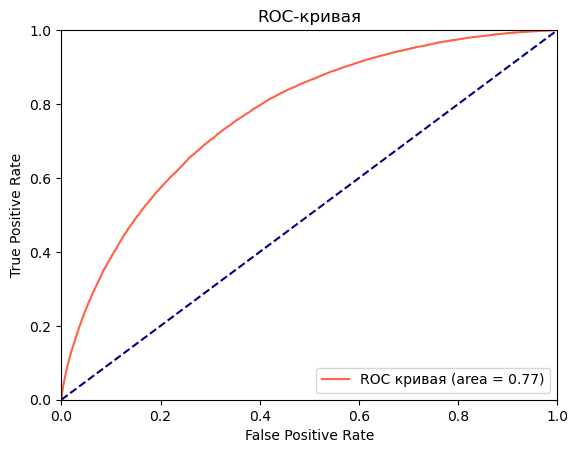

In [44]:
plt.plot(fpr, tpr, color='tomato',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkmagenta', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show();

## Обучение на полном датасете и сериализация

In [19]:
best_pipe.fit(df.drop('flag', axis=1), df['flag'])

Pipeline(steps=[('model',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.024,
                                min_child_samples=40, n_estimators=3205,
                                num_leaves=87, random_state=42, reg_alpha=1.029,
                                reg_lambda=48.5))])

In [21]:
with open('final_model.pkl', 'wb') as file:
    dill.dump({
        'model': best_pipe,
        'metadata': {
            'name': 'Модель кредитного  риск-менеджмента',
            'type': type(best_pipe.named_steps['model']).__name__,
            'version': 1.0,
            'roc_auc': best_score,
            'author': 'Sergey Tuktarov',
            'model_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        }
    }, file)